In [1]:
# ========================================
# 0) Install Requirements
# ========================================
!pip install -q ultralytics opencv-python-headless tqdm pyyaml

# ========================================
# 1) Mount Google Drive
# ========================================
from google.colab import drive
drive.mount('/content/drive')

# ========================================
# 2) Imports
# ========================================
import os, glob, random, shutil
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# ========================================
# 3) Dataset Root Path (YOUR DRIVE PATH)
# ========================================
DATASET_ROOT = "/content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8"
DATA_YAML_PATH = os.path.join(DATASET_ROOT, "data.yaml")

if not os.path.exists(DATA_YAML_PATH):
    raise FileNotFoundError(f"❌ data.yaml not found at: {DATA_YAML_PATH}")

print("✅ Using dataset root:", DATASET_ROOT)
print("✅ Using YAML:", DATA_YAML_PATH)


Mounted at /content/drive
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Using dataset root: /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8
✅ Using YAML: /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8/data.yaml


In [2]:
# ========================================
# 4) Load YAML and class names
# ========================================
with open(DATA_YAML_PATH, "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"]
if isinstance(class_names, dict):
    class_names = [class_names[i] for i in range(len(class_names))]

print("✅ Classes:", class_names)

# ========================================
# 5) Dataset split folders (Roboflow structure)
# ========================================
train_img_dir = os.path.join(DATASET_ROOT, "train", "images")
train_lbl_dir = os.path.join(DATASET_ROOT, "train", "labels")

val_img_dir   = os.path.join(DATASET_ROOT, "valid", "images")
val_lbl_dir   = os.path.join(DATASET_ROOT, "valid", "labels")

test_img_dir  = os.path.join(DATASET_ROOT, "test", "images")
test_lbl_dir  = os.path.join(DATASET_ROOT, "test", "labels")

# Verify structure exists
for p in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir, test_img_dir, test_lbl_dir]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"❌ Missing folder: {p}")

print("✅ Dataset structure verified successfully!")

# ========================================
# 6) Create processed dataset output folder (local /content for speed)
# ========================================
WORKING_PATH = "/content/processed_dataset"
if os.path.exists(WORKING_PATH):
    shutil.rmtree(WORKING_PATH)

for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(WORKING_PATH, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(WORKING_PATH, split, "labels"), exist_ok=True)

print("✅ Processed dataset output:", WORKING_PATH)

✅ Classes: ['0', '1', '2', '3', '4', '5', '6', '7']
✅ Dataset structure verified successfully!
✅ Processed dataset output: /content/processed_dataset


In [3]:
# ========================================
# 7) Hybrid Defog/Dehaze function (Notebook Version)
# ========================================
def apply_hybrid_v2(img_bgr: np.ndarray) -> np.ndarray:
    I = img_bgr.astype(np.float32) / 255.0

    # Dark Channel
    dark = cv2.min(cv2.min(I[:, :, 0], I[:, :, 1]), I[:, :, 2])
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    dark = cv2.erode(dark, kernel)

    # Atmospheric light estimation (top 0.1%)
    flat = dark.ravel()
    k = max(1, int(len(flat) * 0.001))
    idx = np.argsort(flat)[-k:]
    A = np.mean(I.reshape(-1, 3)[idx], axis=0)

    # Transmission estimate
    omega = 0.95
    t = 1 - omega * dark / (np.max(A) + 1e-6)
    t = np.clip(t, 0.1, 1.0)

    # Recover radiance
    J = np.empty_like(I)
    for c in range(3):
        J[:, :, c] = (I[:, :, c] - A[c]) / t + A[c]
    J = np.clip(J, 0, 1)

    # Gamma correction
    gamma = 1.2
    J = np.power(J, 1 / gamma)
    out = (J * 255).astype(np.uint8)

    # CLAHE enhancement
    lab = cv2.cvtColor(out, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    out = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

    # Sharpen
    blurred = cv2.GaussianBlur(out, (0, 0), 3)
    out = cv2.addWeighted(out, 1.5, blurred, -0.5, 0)

    return out

# ========================================
# 8) Preprocessing Functions (ThreadPool)
# ========================================
def process_one(img_path, in_label_dir, out_img_dir, out_label_dir):
    img = cv2.imread(img_path)
    if img is None:
        return

    enhanced = apply_hybrid_v2(img)
    img_name = os.path.basename(img_path)

    # Save enhanced image
    cv2.imwrite(os.path.join(out_img_dir, img_name), enhanced)

    # Copy label
    label_name = os.path.splitext(img_name)[0] + ".txt"
    src_label = os.path.join(in_label_dir, label_name)
    if os.path.exists(src_label):
        shutil.copy(src_label, os.path.join(out_label_dir, label_name))

def process_split(in_img_dir, in_lbl_dir, out_split_dir, workers=8):
    out_img_dir = os.path.join(out_split_dir, "images")
    out_lbl_dir = os.path.join(out_split_dir, "labels")

    imgs = sorted(
        glob.glob(os.path.join(in_img_dir, "*.jpg")) +
        glob.glob(os.path.join(in_img_dir, "*.png")) +
        glob.glob(os.path.join(in_img_dir, "*.jpeg"))
    )

    worker_fn = partial(
        process_one,
        in_label_dir=in_lbl_dir,
        out_img_dir=out_img_dir,
        out_label_dir=out_lbl_dir
    )

    with ThreadPoolExecutor(max_workers=workers) as executor:
        list(tqdm(executor.map(worker_fn, imgs), total=len(imgs), desc=f"Processing {os.path.basename(out_split_dir)}"))

# ========================================
# 9) Run preprocessing
# ========================================
print("⏳ Processing train...")
process_split(train_img_dir, train_lbl_dir, os.path.join(WORKING_PATH, "train"), workers=8)

print("⏳ Processing valid...")
process_split(val_img_dir, val_lbl_dir, os.path.join(WORKING_PATH, "valid"), workers=8)

print("⏳ Processing test...")
process_split(test_img_dir, test_lbl_dir, os.path.join(WORKING_PATH, "test"), workers=8)

print("✅ Preprocessing complete!")

⏳ Processing train...


Processing train: 0it [00:00, ?it/s]


⏳ Processing valid...


Processing valid: 0it [00:00, ?it/s]


⏳ Processing test...


Processing test: 0it [00:00, ?it/s]

✅ Preprocessing complete!


In [5]:
import os, glob, yaml, shutil
from ultralytics import YOLO

# ========================================
# ✅ (OPTIONAL) Clean old runs folder
# This prevents loading old best.pt
# ========================================
if os.path.exists("/content/runs"):
    shutil.rmtree("/content/runs")
    print("✅ Old runs folder removed.")

# ========================================
# 10) Create YAML for processed dataset
# ========================================
processed_yaml_path = "/content/processed_data.yaml"

processed_yaml = {
    "path": WORKING_PATH,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(class_names),
    "names": class_names
}

with open(processed_yaml_path, "w") as f:
    yaml.dump(processed_yaml, f)

print("✅ Processed YAML saved:", processed_yaml_path)

# ========================================
# ✅ Check processed dataset is not empty
# ========================================
train_count = len(glob.glob(os.path.join(WORKING_PATH, "train/images/*")))
val_count   = len(glob.glob(os.path.join(WORKING_PATH, "valid/images/*")))
test_count  = len(glob.glob(os.path.join(WORKING_PATH, "test/images/*")))

print("✅ Train images:", train_count)
print("✅ Valid images:", val_count)
print("✅ Test images :", test_count)

if train_count == 0 or val_count == 0:
    raise FileNotFoundError("❌ Processed dataset is empty. Preprocessing did not save images correctly.")

# ========================================
# 11) Train YOLOv8
# ========================================
model = YOLO("yolov8m.pt")  # change to yolov8s.pt for faster training

results = model.train(
    data=processed_yaml_path,
    epochs=10,
    imgsz=640,
    batch=16,
    name="hybrid_thesis_v2",
    project="/content/runs",
    exist_ok=True
)

# ✅ Print actual training save directory
save_dir = results.save_dir
print("✅ Training results saved in:", save_dir)

# ========================================
# 12) Load best.pt (UPDATED: search ONLY inside your run)
# ========================================
best_candidates = glob.glob(os.path.join(save_dir, "weights/best.pt"))

if len(best_candidates) == 0:
    raise FileNotFoundError("❌ best.pt not found. Training may have failed or not finished.")

best_weight = best_candidates[0]
print("✅ Found best.pt:", best_weight)

best_model = YOLO(best_weight)


✅ Old runs folder removed.
✅ Processed YAML saved: /content/processed_data.yaml
✅ Train images: 0
✅ Valid images: 0
✅ Test images : 0


FileNotFoundError: ❌ Processed dataset is empty. Preprocessing did not save images correctly.

In [ ]:
# ========================================
# 13) Evaluate on TEST Set
# ========================================
metrics = best_model.val(data=processed_yaml_path, split="test")

print("\n✅ TEST RESULTS")
print("mAP@50:", metrics.box.map50)
print("mAP@50-95:", metrics.box.map)
print("Precision:", metrics.results_dict.get("metrics/precision(B)"))
print("Recall:", metrics.results_dict.get("metrics/recall(B)"))

# ========================================
# 14) Predict on random test image
# ========================================
test_imgs = glob.glob(os.path.join(WORKING_PATH, "test", "images", "*.jpg")) + \
            glob.glob(os.path.join(WORKING_PATH, "test", "images", "*.png")) + \
            glob.glob(os.path.join(WORKING_PATH, "test", "images", "*.jpeg"))

if len(test_imgs) == 0:
    raise FileNotFoundError("❌ No test images found in processed dataset.")

img_path = random.choice(test_imgs)
print("✅ Predicting on:", img_path)

pred = best_model.predict(img_path, conf=0.25)[0]

plt.figure(figsize=(14, 9))
plt.imshow(cv2.cvtColor(pred.plot(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

[WORK 01] YOLO model: YOLOv8m, Ultralytics version: 8.3.246

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Using dataset root: /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8
✅ Using YAML: /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8/data.yaml
✅ Classes: ['0', '1', '2', '3', '4', '5', '6', '7']
✅ Dataset structure verified successfully!
✅ Processed dataset output: /content/processed_dataset
⏳ Processing train...

✅ Found 3148 images in /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8/train/images


Processing train: 100%|██████████| 3148/3148 [10:16<00:00,  5.11it/s]


⏳ Processing valid...

✅ Found 300 images in /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8/valid/images


Processing valid: 100%|██████████| 300/300 [00:55<00:00,  5.40it/s]


⏳ Processing test...

✅ Found 150 images in /content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8/test/images


Processing test: 100%|██████████| 150/150 [00:28<00:00,  5.28it/s]



✅ Processed Train images: 3148
✅ Processed Valid images: 300
✅ Processed Test images : 150
✅ Processed YAML saved: /content/processed_data.yaml
Ultralytics 8.3.246 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/processed_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False,

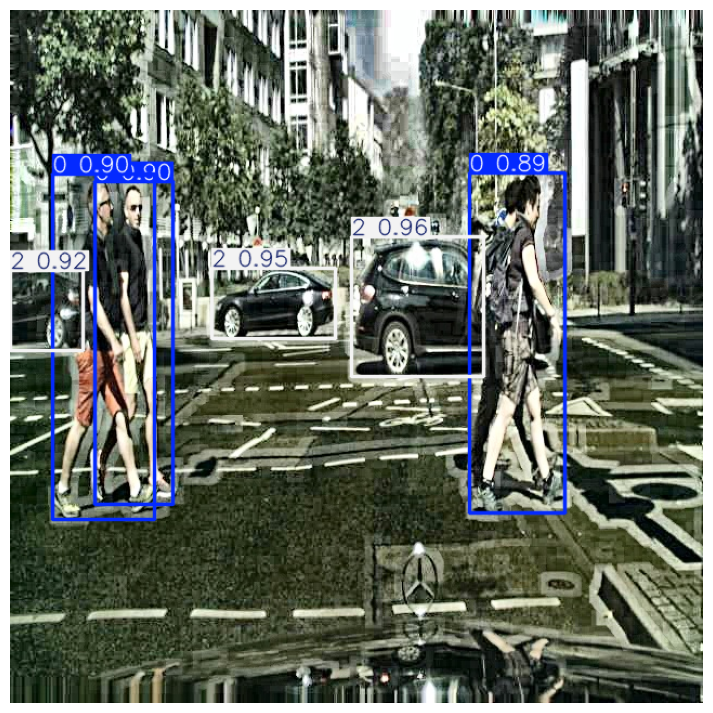

In [6]:
# ========================================
# 0) Install Requirements
# ========================================
!pip install -q ultralytics opencv-python-headless tqdm pyyaml

# ========================================
# 1) Mount Google Drive
# ========================================
from google.colab import drive
drive.mount('/content/drive')

# ========================================
# 2) Imports
# ========================================
import os, glob, random, shutil
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# ========================================
# 3) Dataset Root Path (YOUR PATH)
# ========================================
DATASET_ROOT = "/content/drive/MyDrive/yolo/Foggy Cityscapes Dataset.v1i.yolov8"
DATA_YAML_PATH = os.path.join(DATASET_ROOT, "data.yaml")

if not os.path.exists(DATA_YAML_PATH):
    raise FileNotFoundError(f"❌ data.yaml not found at: {DATA_YAML_PATH}")

print("✅ Using dataset root:", DATASET_ROOT)
print("✅ Using YAML:", DATA_YAML_PATH)

# ========================================
# 4) Load YAML and class names
# ========================================
with open(DATA_YAML_PATH, "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"]
if isinstance(class_names, dict):
    class_names = [class_names[i] for i in range(len(class_names))]

print("✅ Classes:", class_names)

# ========================================
# 5) Dataset folders
# ========================================
train_img_dir = os.path.join(DATASET_ROOT, "train", "images")
train_lbl_dir = os.path.join(DATASET_ROOT, "train", "labels")

val_img_dir   = os.path.join(DATASET_ROOT, "valid", "images")
val_lbl_dir   = os.path.join(DATASET_ROOT, "valid", "labels")

test_img_dir  = os.path.join(DATASET_ROOT, "test", "images")
test_lbl_dir  = os.path.join(DATASET_ROOT, "test", "labels")

for p in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir, test_img_dir, test_lbl_dir]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"❌ Missing folder: {p}")

print("✅ Dataset structure verified successfully!")

# ========================================
# 6) Create processed dataset output folder
# ========================================
WORKING_PATH = "/content/processed_dataset"
if os.path.exists(WORKING_PATH):
    shutil.rmtree(WORKING_PATH)

for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(WORKING_PATH, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(WORKING_PATH, split, "labels"), exist_ok=True)

print("✅ Processed dataset output:", WORKING_PATH)

# ========================================
# 7) Hybrid Defog/Dehaze Enhancement (Notebook Version)
# ========================================
def apply_hybrid_v2(img_bgr: np.ndarray) -> np.ndarray:
    I = img_bgr.astype(np.float32) / 255.0

    dark = cv2.min(cv2.min(I[:, :, 0], I[:, :, 1]), I[:, :, 2])
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    dark = cv2.erode(dark, kernel)

    flat = dark.ravel()
    k = max(1, int(len(flat) * 0.001))
    idx = np.argsort(flat)[-k:]
    A = np.mean(I.reshape(-1, 3)[idx], axis=0)

    omega = 0.95
    t = 1 - omega * dark / (np.max(A) + 1e-6)
    t = np.clip(t, 0.1, 1.0)

    J = np.empty_like(I)
    for c in range(3):
        J[:, :, c] = (I[:, :, c] - A[c]) / t + A[c]
    J = np.clip(J, 0, 1)

    gamma = 1.2
    J = np.power(J, 1 / gamma)
    out = (J * 255).astype(np.uint8)

    lab = cv2.cvtColor(out, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    out = cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

    blurred = cv2.GaussianBlur(out, (0, 0), 3)
    out = cv2.addWeighted(out, 1.5, blurred, -0.5, 0)

    return out

# ========================================
# 8) Recursive Image Finder
# ========================================
def collect_images(folder):
    exts = {".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"}
    files = [p for p in Path(folder).rglob("*") if p.suffix.lower() in exts]
    return sorted([str(p) for p in files])

# ========================================
# 9) Preprocess & Copy Labels (ThreadPool)
# ========================================
def process_one(img_path, in_label_dir, out_img_dir, out_label_dir):
    img = cv2.imread(img_path)
    if img is None:
        return

    enhanced = apply_hybrid_v2(img)
    img_name = os.path.basename(img_path)

    # Save enhanced
    cv2.imwrite(os.path.join(out_img_dir, img_name), enhanced)

    # Copy label
    label_name = os.path.splitext(img_name)[0] + ".txt"
    src_label = os.path.join(in_label_dir, label_name)
    if os.path.exists(src_label):
        shutil.copy(src_label, os.path.join(out_label_dir, label_name))

def process_split(in_img_dir, in_lbl_dir, out_split_dir, workers=8):
    out_img_dir = os.path.join(out_split_dir, "images")
    out_lbl_dir = os.path.join(out_split_dir, "labels")

    imgs = collect_images(in_img_dir)

    print(f"\n✅ Found {len(imgs)} images in {in_img_dir}")
    if len(imgs) == 0:
        raise FileNotFoundError(f"❌ No images found in {in_img_dir}")

    worker_fn = partial(
        process_one,
        in_label_dir=in_lbl_dir,
        out_img_dir=out_img_dir,
        out_label_dir=out_lbl_dir
    )

    with ThreadPoolExecutor(max_workers=workers) as executor:
        list(tqdm(executor.map(worker_fn, imgs), total=len(imgs),
                  desc=f"Processing {os.path.basename(out_split_dir)}"))

# Run preprocessing
print("⏳ Processing train...")
process_split(train_img_dir, train_lbl_dir, os.path.join(WORKING_PATH, "train"))

print("⏳ Processing valid...")
process_split(val_img_dir, val_lbl_dir, os.path.join(WORKING_PATH, "valid"))

print("⏳ Processing test...")
process_split(test_img_dir, test_lbl_dir, os.path.join(WORKING_PATH, "test"))

# Verify output
train_count = len(glob.glob(os.path.join(WORKING_PATH, "train/images/*")))
val_count   = len(glob.glob(os.path.join(WORKING_PATH, "valid/images/*")))
test_count  = len(glob.glob(os.path.join(WORKING_PATH, "test/images/*")))

print("\n✅ Processed Train images:", train_count)
print("✅ Processed Valid images:", val_count)
print("✅ Processed Test images :", test_count)

if train_count == 0 or val_count == 0:
    raise FileNotFoundError("❌ Processed dataset is empty. Something went wrong in preprocessing.")

# ========================================
# 10) Create YAML for processed dataset
# ========================================
processed_yaml_path = "/content/processed_data.yaml"

processed_yaml = {
    "path": WORKING_PATH,
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(class_names),
    "names": class_names
}

with open(processed_yaml_path, "w") as f:
    yaml.dump(processed_yaml, f)

print("✅ Processed YAML saved:", processed_yaml_path)

# ========================================
# 11) Train YOLOv8
# ========================================
# optional: clear old runs so old weights don't mix
if os.path.exists("/content/runs"):
    shutil.rmtree("/content/runs")
    print("✅ Old /content/runs removed.")

model = YOLO("yolov8m.pt")  # change to yolov8s.pt if faster

results = model.train(
    data=processed_yaml_path,
    epochs=10,
    imgsz=640,
    batch=16,
    name="hybrid_thesis_v2",
    project="/content/runs",
    exist_ok=True
)

save_dir = results.save_dir
print("✅ Training saved at:", save_dir)

# ========================================
# 12) Load best.pt automatically
# ========================================
best_weight = os.path.join(save_dir, "weights", "best.pt")
if not os.path.exists(best_weight):
    raise FileNotFoundError(f"❌ best.pt not found at {best_weight}")

print("✅ Found best.pt:", best_weight)
best_model = YOLO(best_weight)

# ========================================
# 13) Evaluate on TEST
# ========================================
metrics = best_model.val(data=processed_yaml_path, split="test")

print("\n✅ TEST RESULTS")
print("mAP@50:", metrics.box.map50)
print("mAP@50-95:", metrics.box.map)
print("Precision:", metrics.results_dict.get("metrics/precision(B)"))
print("Recall:", metrics.results_dict.get("metrics/recall(B)"))

# ========================================
# 14) Predict on random test image
# ========================================
test_imgs = glob.glob(os.path.join(WORKING_PATH, "test", "images", "*"))
img_path = random.choice(test_imgs)
print("✅ Predicting on:", img_path)

pred = best_model.predict(img_path, conf=0.25)[0]

plt.figure(figsize=(14, 9))
plt.imshow(cv2.cvtColor(pred.plot(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


[WORK 02]